## In this notebook is divided into two parts in first part we will emulate Potential Temperature variable of the WRF data and in second part we will emulate Pressure. We have saprately fetched the data from 2019-05-01 to 2019-05-31 in pickel files. 

## The location we will focus is near Lamont, Oklahoma also called Southern Great Plains (SGP). This location plays a important role as it is an atmospheric observatory that was the first field measurement site established by the Atmospheric Radiation Measurement (ARM) user facility. This observatory is the world’s largest and most extensive climate research facility.

## The data will be divided in 70% training and 30% testing, ie Model will be roughly trained on first 20 days and evalute on next 10 days.

### Note: Difference between Potential Temperature and Regular Temperature is that Potential Temperature is not affected by the physical lifting or sinking associated with flow over obstacles or large-scale atmospheric turbulence. A parcel of air moving over a small mountain will expand and cool as it ascends the slope, then compress and warm as it descends on the other side- but the potential temperature will not change in the absence of heating, cooling, evaporation, or condensation (processes that exclude these effects are referred to as dry adiabatic). Potential temperature is a more dynamically important quantity than the actual temperature


In [34]:
# Stating with the relevent Imports

In [ ]:
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
import netCDF4
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import autokeras as ak
from math import sqrt
from tensorflow.keras.regularizers import l2, l1
from mpl_toolkits.basemap import Basemap
import argparse
import matplotlib as mpl

### Retreiving data from Pickel file

In [35]:
datafile = open('PickleDataFiles/wrfout_d01_2019_05_01_to_2019_05_31_TPWHNO', 'rb')      
data = pickle.load(datafile) 

### For this notebook we will focus on 'latitude', 'longitude', 'temperature' variables

In [3]:
data.keys()

dict_keys(['times', 'latitude', 'longitude', 'temperature', 'xWind', 'yWind', 'zWind', 'pressure', 'no2', 'no', 'o3', 'hno3', 'h2o2'])

### First Explore the data:

In [41]:
print('times :' + str(len(data['times'])))
print('Lat :' + str(data['latitude'].shape))
print('Lon :' + str(data['longitude'].shape))
print('Temperature :' + str(data['temperature'].shape))

times :744
Lat :(29, 29)
Lon :(29, 29)
Temperature :(744, 29, 29, 29)


- We can see above that total we have 29*29 Latitude and Longitude Points
- We have 744 data point for a month ie, we have data for each hour (31*24 = 744)
- For Temperature we have 29 level of the data and at each level we have 29*29 gird points at each lat-lon point

### Lets Visualize the Temperature Data, we will plot the bottom most level of the temperature

In [46]:
minLat=-20
maxLat=80
minLon=-180
maxLon=30

In [47]:
temperature_plot=list(np.concatenate(data['temperature'][0][0]).flat)#zero level
latitude_plot = list(np.concatenate(data['latitude']).flat)
longitude_plot = list(np.concatenate(data['longitude']).flat)

In [76]:
(data['temperature']).shape

(744, 29, 29, 29)

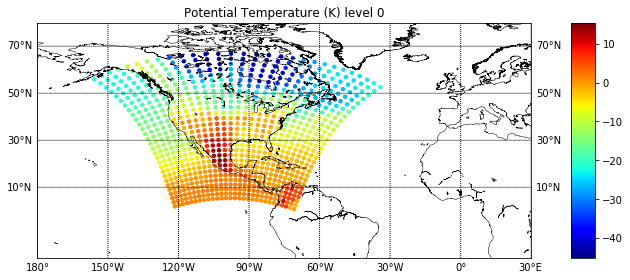

In [50]:
plt.figure(figsize=(10,8))
m = Basemap(projection='cyl', resolution='l',llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat,lat_0=20.,lon_0=-10.,lat_ts=10.)
#'cyl'
#m = Basemap(projection='cyl', resolution='l',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, lat_1=32,lat_2=45,lon_0=-95)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
#GET OCO2 DATA
'''# filter to get oco2 and gosat data seperately
oco2_data = data_set[data_set['dstype'].str.contains("oco2")]
print('Number of OCO2 rows= ' + str(len(oco2_data)))
'''
#    plt.clim(380, 420)
lon_oco2 = np.array(longitude_plot)
lat_oco2 = np.array(latitude_plot)
yrecon_temp = np.array(temperature_plot)


m.scatter(lon_oco2, lat_oco2, c=yrecon_temp, s=20, cmap=plt.cm.jet, edgecolors=None, linewidth=0)
m.colorbar(mappable=None, location='right', size='5%', pad='8%', fig=None, ax=None)
plt.title("Potential Temperature (K) level 0")
#plt.savefig('Potential Temperature (K) level 0.png')
plt.show()

### As we can see as we move from bottom to top the temperature decreases, which is kind of intuitive

# Now Lets prepare data for our model

### The Latitude and Longitude points near the ARM's station Lamont, Ok can be found on the Grid Points (15,13) in our Latitude and Longitude data

In [37]:
print('Latitude_OK: '+str(data['latitude'][15][13]))
print('Longitude_OK: '+str(data['longitude'][15][13]))

Latitude_OK : 37.17219


In [292]:
#'UMBC'
print(data['latitude'][17][20])
print(data['longitude'][17][20])

39.589718
-76.512085


In [294]:
#Florida
print(data['latitude'][12][19])
print(data['longitude'][12][19])

28.999317
-82.37851


In [295]:
#Wisconsin
print(data['latitude'][18][15])
print(data['longitude'][18][15])

43.92749
-91.31976


### Next we will retrieve all the 29 level data point of all the variables at the ARM's station Lamont, Ok. Storing them to respective list

In [52]:
lat_loc=15
lon_loc=13
temperature =[]
pressure = []
xWind = []
yWind = []
zWind = []
no2 = []
no = []
o3 = []
hno3 = []
h2o2 = []
for i in range(len(data['temperature'])):
    temperature.append(data['temperature'][i][lat_loc][lon_loc])
    pressure.append(data['pressure'][i][lat_loc][lon_loc])
    xWind.append(data['xWind'][i][lat_loc][lon_loc])
    yWind.append(data['yWind'][i][lat_loc][lon_loc])
    zWind.append(data['zWind'][i][lat_loc][lon_loc])
    no2.append(data['no2'][i][lat_loc][lon_loc])
    no.append(data['no'][i][lat_loc][lon_loc])
    o3.append(data['o3'][i][lat_loc][lon_loc])
    hno3.append(data['hno3'][i][lat_loc][lon_loc])
    h2o2.append(data['h2o2'][i][lat_loc][lon_loc])
    

### As this is time series data so first thing came to mind is to use RNN. A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step. 
### This is Univariate RNN model, so our input and output variable are both Temperature.

### For RNN we need 3D format, and split the data into 3 steps such that first three steps are input and fourth step is the output

In [58]:

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [59]:
X,y=split_sequence(temperature, 3)

In [60]:
X.shape

(741, 3, 29)

In [147]:
y.shape

(741, 29)

### Splitting the data with test size of 33 %

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [70]:
print(X_train.shape)#496 are training data points
print(X_test.shape)#245 are testing data points

(496, 3, 29)
(245, 3, 29)


### In order to make the model learning easy, lets standardise the input data

In [71]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)


### Creating our own loss function as root mean square

In [74]:
def my_objective(y_pred,  y_true):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

How autokeras library works is that, it gives us best neural network architecture on the given input data.

We can use different block such as DenseBlock, ConvBlock, RNNBlock based on our problem.

The input_node is to accept the input datato the model. 
Then we added RNN block with few parameter inputs. This requires little bit of hyperparameter tunning on below variables.
    - return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False. This was set to True to get the full sequence.
    - bidirectional: It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.
    - layer_type: it can be lstm/GRU. if left empty the RNNBlock will identify the best one.
    
For the ouptut we define RegressionHead with our own loss.

Lastly setting the autokeras AutoModel, specifying input_node, output_node and max_trials. In each epoch the autokers will try different architecture upto max_trial

Then standard Model.fit with input and output data with number of epochs
    

In [210]:
input_node = ak.Input() 
#out_node = ak.Normalization()(input_node)
#output_node1=ak.ConvBlock()(out_node)
output_node2 = ak.RNNBlock(return_sequences=True,bidirectional=True,layer_type='lstm')(input_node) 
#output_node = ak.DenseBlock()(output_node) #optional
#output_node = ak.SpatialReduction()(output_node) #optional
#output_node3=ak.DenseBlock(use_batchnorm=True)(output_node2)
output_node = ak.RegressionHead(loss=my_objective)(output_node2)

auto_model = ak.AutoModel(inputs=input_node,outputs=output_node,overwrite=True,max_trials=50)

In [211]:
auto_model.fit(X_train, y_train, epochs=100)

Trial 11 Complete [00h 00m 20s]
val_loss: 2.3830630779266357

Best val_loss So Far: 0.4380044639110565
Total elapsed time: 00h 04m 00s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
17/17 [==============================] - 1s 57ms/step - loss: 15.2070 - mean_squared_error: 231.3304 - val_loss: 14.6693 - val_mean_squared_error: 215.2327
Epoch 2/100
17/17 [==============================] - 0s 10ms/step - loss: 13.7920 - mean_squared_error: 190.8575 - val_loss: 11.7239 - val_mean_squared_error: 137.4789
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 9.6522 - mean_squared_error: 95.1050 - val_loss: 6.7258 - val_mean_squared_error: 45.2680
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 5.0150 - mean_squared_error: 26.2823 - val_loss: 3.0625 - val_mean_squared_error: 9.4043
Epoch 5/100
17/17 [==============================] - 0s 10ms/step - loss: 2.5486 - mean_squared_error: 6.5698 - val_loss: 2.2829 - val_mean_squared_error: 5.2159
Ep

17/17 [==============================] - 0s 10ms/step - loss: 0.3585 - mean_squared_error: 0.1293 - val_loss: 0.3525 - val_mean_squared_error: 0.1263


### Now we can make predictions on the model we just trained.

In [212]:
predicted_=auto_model.predict(X_test)

### In order to check what neural network architecture we got from autokeras we have to first export the model

In [215]:
auto_model_t=auto_model.export_model()

### Lets save the model config to the file

In [216]:
f = open("Temperature_Model_config.txt", "w")
f.write(str(auto_model_t.get_config()))
f.close()

In [226]:
#This set of code will tell the best architecture we get in our input data
auto_model_t.get_config()

{'name': 'functional_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 3, 29),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Bidirectional',
   'config': {'name': 'bidirectional',
    'trainable': True,
    'dtype': 'float32',
    'layer': {'class_name': 'LSTM',
     'config': {'name': 'lstm',
      'trainable': True,
      'dtype': 'float32',
      'return_sequences': True,
      'return_state': False,
      'go_backwards': False,
      'stateful': False,
      'unroll': False,
      'time_major': False,
      'units': 29,
      'activation': 'tanh',
      'recurrent_activation': 'sigmoid',
      'use_bias': True,
      'kernel_initializer': {'class_name': 'GlorotUniform',
       'config': {'seed': None}},
      'recurrent_initializer': {'class_name': 'Orthogonal',
       'config': {'gain': 1.0, 'seed': None}},
      'bias_initializer': {'cl

### We got Two LSTM bidirectional LSTM layer with activation fuction tanh and 29 neurons

### one Flatten Layer followed by denselayer with activation fuction tanh and 29 neurons

In [81]:
predicted

array([[16.93521 , 16.58864 , 15.9749  , ..., 15.637071, 15.738349,
        15.794342],
       [16.008745, 15.687785, 15.164763, ..., 14.940658, 14.945657,
        14.97014 ],
       [18.071995, 17.645918, 17.050299, ..., 16.539598, 16.701109,
        16.824783],
       ...,
       [18.016712, 17.601236, 16.992369, ..., 16.476011, 16.650408,
        16.772795],
       [18.237518, 17.768837, 17.21725 , ..., 16.677183, 16.847479,
        16.959867],
       [16.791111, 16.441303, 15.841687, ..., 15.524469, 15.603385,
        15.651535]], dtype=float32)

### Regression analysis parameters:

### R-squared is a relative measure of fit, R-squared is around 96% reveals that 96% of the data fits the regression model.
### RMSE is an absolute measure of fit. Lower values of RMSE indicate better fit.

In [140]:
r2 = r2_score(predicted,y_test)
rmse = sqrt(mean_squared_error(predicted,y_test))

In [141]:
print(r2)
print(rmse)

0.9671764423455104
0.38208076062613766


### Lets Visualize the Test vs Predicted data

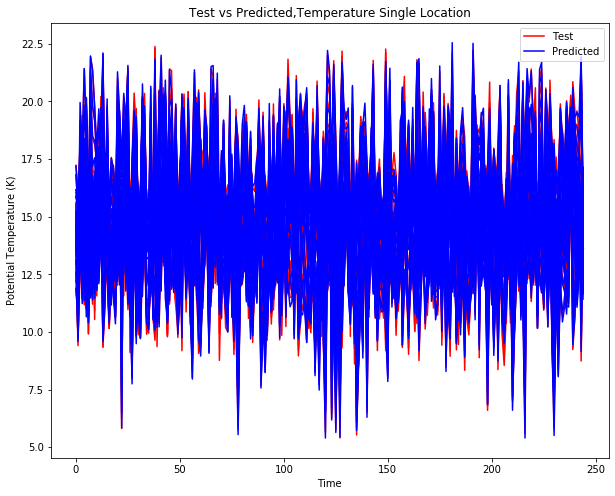

In [187]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted,Temperature Single Location')
plt.xlabel('Time')
plt.ylabel('Potential Temperature (K)')
plt.plot(y_test, 'r',label='Test')
plt.plot(predicted, 'b',label='Predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('Temperature Single Location.png')
#plt.legend()
plt.show()

### The plot looks convencing as almost all test data points are covered by predicted data. To get a closer look lets plot the single time and location

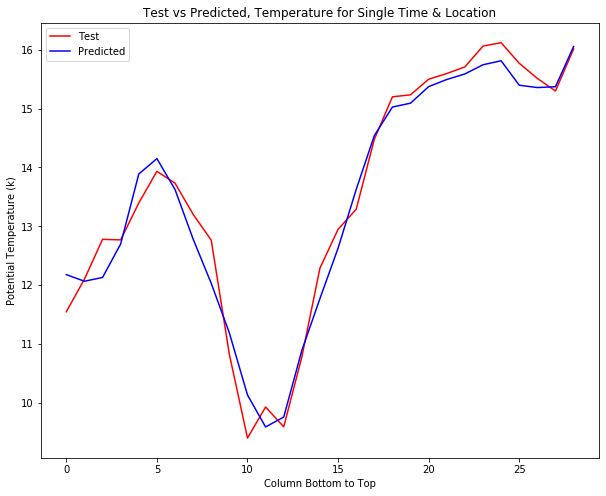

In [218]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Temperature for Single Time & Location')
plt.xlabel('Column Bottom to Top')
plt.ylabel('Potential Temperature (k)')
plt.plot(y_test[1], 'r',label= 'Test')
plt.plot(predicted[1], 'b', label= 'Predicted')
plt.legend()
plt.savefig('Temperature for Single Time & Location_1.png')
plt.show()
#plt.savefig('Data/autoKeras_500_trials_1000epochs.png')

### With the model trained on the given architechture, The Predicted data captured almost exact relationship  as testing data

# Part Two: Emulating Pressure

### We will be taking similar approach to emulate Pressure as we did for Temperature.

### This is Univariate RNN model, so our input and output variable are both Pressure.
### For RNN we need 3D format, and split the data into 3 steps such that first three steps are input and fourth step is the output

In [113]:
X_pressure,y_pressure=split_sequence(pressure, 3)

break
741


In [114]:
y_pressure.shape

(741, 29)

### Splitting the data with test size of 33 %

In [115]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pressure, y_pressure, test_size=0.33, random_state=42)

### In order to make the model learning easy, lets standardise the input data

In [116]:
scaler = MinMaxScaler(feature_range=(0,1))
X_train_p = scaler.fit_transform(X_train_p.reshape(X_train_p.shape[0], -1)).reshape(X_train_p.shape)
X_test_p = scaler.transform(X_test_p.reshape(X_test_p.shape[0], -1)).reshape(X_test_p.shape)

### Creating our own loss function as root mean square

In [117]:
def my_objective(y_pred,  y_true):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred-y_true)))

### As I have explained earlier about the Auto Keras.
Steps involved
- Create Input node
- Specify layer with RNN Block, with its own hyperparameter
- Create output node
- Specify AutoModel with hyper parameter mainly on input node, output node and max_trials

In [118]:
input_node_p = ak.Input() 
#out_node = ak.Normalization()(input_node)
#output_node1=ak.ConvBlock()(out_node)
output_node2_p = ak.RNNBlock(return_sequences=True,bidirectional=True)(input_node_p) 
#output_node = ak.DenseBlock()(output_node) #optional
#output_node = ak.SpatialReduction()(output_node) #optional
#output_node3=ak.DenseBlock(use_batchnorm=True)(output_node2)
output_node_p = ak.RegressionHead(loss=my_objective)(output_node2_p)

auto_model_p = ak.AutoModel(inputs=input_node_p,outputs=output_node_p,overwrite=True,max_trials=100)

### Train the model using fit function, with input data, output data and number epochs

In [119]:
auto_model_p.fit(X_train_p, y_train_p, epochs=1000)

Trial 21 Complete [00h 02m 48s]
val_loss: 93.99424743652344

Best val_loss So Far: 22.857309341430664
Total elapsed time: 00h 58m 40s
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
17/17 [==============================] - 1s 53ms/step - loss: 450.6493 - mean_squared_error: 203181.8750 - val_loss: 457.7345 - val_mean_squared_error: 209551.5938
Epoch 2/1000
17/17 [==============================] - 0s 11ms/step - loss: 448.1747 - mean_squared_error: 200956.4688 - val_loss: 453.8959 - val_mean_squared_error: 206052.2031
Epoch 3/1000
17/17 [==============================] - 0s 11ms/step - loss: 443.8531 - mean_squared_error: 197102.4219 - val_loss: 449.4245 - val_mean_squared_error: 202013.2656
Epoch 4/1000
17/17 [==============================] - 0s 11ms/step - loss: 439.5142 - mean_squared_error: 193269.8906 - val_loss: 445.3173 - val_mean_squared_error: 198338.5469
Epoch 5/1000
17/17 [==============================] - 0s 11ms/step - loss: 435.5522 - mean_squared_error: 189803.0625 - 

17/17 [==============================] - 0s 11ms/step - loss: 198.3214 - mean_squared_error: 39426.0859 - val_loss: 205.7589 - val_mean_squared_error: 42370.1016
Epoch 93/1000
17/17 [==============================] - 0s 11ms/step - loss: 196.0367 - mean_squared_error: 38524.7773 - val_loss: 203.4908 - val_mean_squared_error: 41441.8789
Epoch 94/1000
17/17 [==============================] - 0s 11ms/step - loss: 193.7663 - mean_squared_error: 37639.5000 - val_loss: 201.2374 - val_mean_squared_error: 40529.8164
Epoch 95/1000
17/17 [==============================] - 0s 11ms/step - loss: 191.5107 - mean_squared_error: 36770.1641 - val_loss: 198.9989 - val_mean_squared_error: 39633.8359
Epoch 96/1000
17/17 [==============================] - 0s 11ms/step - loss: 189.2702 - mean_squared_error: 35916.7031 - val_loss: 196.7755 - val_mean_squared_error: 38753.8516
Epoch 97/1000
17/17 [==============================] - 0s 11ms/step - loss: 187.0451 - mean_squared_error: 35079.0312 - val_loss: 194.

Epoch 185/1000
17/17 [==============================] - 0s 11ms/step - loss: 88.3989 - mean_squared_error: 7843.6826 - val_loss: 95.7172 - val_mean_squared_error: 9186.5010
Epoch 186/1000
17/17 [==============================] - 0s 11ms/step - loss: 88.2867 - mean_squared_error: 7823.6357 - val_loss: 95.5813 - val_mean_squared_error: 9160.5049
Epoch 187/1000
17/17 [==============================] - 0s 11ms/step - loss: 88.1821 - mean_squared_error: 7804.9800 - val_loss: 95.4535 - val_mean_squared_error: 9136.0898
Epoch 188/1000
17/17 [==============================] - 0s 11ms/step - loss: 88.0848 - mean_squared_error: 7787.6313 - val_loss: 95.3333 - val_mean_squared_error: 9113.1660
Epoch 189/1000
17/17 [==============================] - 0s 11ms/step - loss: 87.9943 - mean_squared_error: 7771.5024 - val_loss: 95.2204 - val_mean_squared_error: 9091.6465
Epoch 190/1000
17/17 [==============================] - 0s 11ms/step - loss: 87.9101 - mean_squared_error: 7756.5200 - val_loss: 95.114

17/17 [==============================] - 0s 11ms/step - loss: 76.0681 - mean_squared_error: 5802.3784 - val_loss: 81.4952 - val_mean_squared_error: 6653.0132
Epoch 280/1000
17/17 [==============================] - 0s 11ms/step - loss: 75.9373 - mean_squared_error: 5782.4565 - val_loss: 81.3425 - val_mean_squared_error: 6628.1250
Epoch 281/1000
17/17 [==============================] - 0s 11ms/step - loss: 75.8047 - mean_squared_error: 5762.2969 - val_loss: 81.1886 - val_mean_squared_error: 6603.1201
Epoch 282/1000
17/17 [==============================] - 0s 11ms/step - loss: 75.6710 - mean_squared_error: 5742.0146 - val_loss: 81.0351 - val_mean_squared_error: 6578.2153
Epoch 283/1000
17/17 [==============================] - 0s 11ms/step - loss: 75.5356 - mean_squared_error: 5721.5127 - val_loss: 80.8795 - val_mean_squared_error: 6553.0093
Epoch 284/1000
17/17 [==============================] - 0s 11ms/step - loss: 75.3969 - mean_squared_error: 5700.5566 - val_loss: 80.7193 - val_mean_sq

17/17 [==============================] - 0s 11ms/step - loss: 56.0644 - mean_squared_error: 3156.0007 - val_loss: 60.5170 - val_mean_squared_error: 3671.0793
Epoch 374/1000
17/17 [==============================] - 0s 11ms/step - loss: 55.8573 - mean_squared_error: 3132.7681 - val_loss: 60.2997 - val_mean_squared_error: 3644.7917
Epoch 375/1000
17/17 [==============================] - 0s 11ms/step - loss: 55.6512 - mean_squared_error: 3109.7319 - val_loss: 60.0838 - val_mean_squared_error: 3618.7588
Epoch 376/1000
17/17 [==============================] - 0s 11ms/step - loss: 55.4461 - mean_squared_error: 3086.8894 - val_loss: 59.8688 - val_mean_squared_error: 3592.9429
Epoch 377/1000
17/17 [==============================] - 0s 11ms/step - loss: 55.2417 - mean_squared_error: 3064.2153 - val_loss: 59.6544 - val_mean_squared_error: 3567.2761
Epoch 378/1000
17/17 [==============================] - 0s 11ms/step - loss: 55.0378 - mean_squared_error: 3041.6675 - val_loss: 59.4398 - val_mean_sq

17/17 [==============================] - 0s 11ms/step - loss: 41.2721 - mean_squared_error: 1711.8687 - val_loss: 44.8301 - val_mean_squared_error: 2015.4222
Epoch 468/1000
17/17 [==============================] - 0s 11ms/step - loss: 41.1502 - mean_squared_error: 1701.7998 - val_loss: 44.7063 - val_mean_squared_error: 2004.3104
Epoch 469/1000
17/17 [==============================] - 0s 11ms/step - loss: 41.0292 - mean_squared_error: 1691.8271 - val_loss: 44.5845 - val_mean_squared_error: 1993.4099
Epoch 470/1000
17/17 [==============================] - 0s 11ms/step - loss: 40.9121 - mean_squared_error: 1682.2028 - val_loss: 44.4590 - val_mean_squared_error: 1982.2151
Epoch 471/1000
17/17 [==============================] - 0s 11ms/step - loss: 40.7952 - mean_squared_error: 1672.6351 - val_loss: 44.3319 - val_mean_squared_error: 1970.9165
Epoch 472/1000
17/17 [==============================] - 0s 11ms/step - loss: 40.6790 - mean_squared_error: 1663.1460 - val_loss: 44.2040 - val_mean_sq

17/17 [==============================] - 0s 11ms/step - loss: 30.3998 - mean_squared_error: 931.5729 - val_loss: 34.2391 - val_mean_squared_error: 1176.2601
Epoch 562/1000
17/17 [==============================] - 0s 11ms/step - loss: 30.2988 - mean_squared_error: 925.4401 - val_loss: 34.1803 - val_mean_squared_error: 1172.2194
Epoch 563/1000
17/17 [==============================] - 0s 11ms/step - loss: 30.2220 - mean_squared_error: 920.7392 - val_loss: 34.0586 - val_mean_squared_error: 1163.9365
Epoch 564/1000
17/17 [==============================] - 0s 11ms/step - loss: 30.1244 - mean_squared_error: 914.8614 - val_loss: 33.9984 - val_mean_squared_error: 1159.8091
Epoch 565/1000
17/17 [==============================] - 0s 11ms/step - loss: 30.0455 - mean_squared_error: 910.0738 - val_loss: 33.8827 - val_mean_squared_error: 1151.9673
Epoch 566/1000
17/17 [==============================] - 0s 11ms/step - loss: 29.9430 - mean_squared_error: 903.9766 - val_loss: 33.8073 - val_mean_squared_

Epoch 609/1000
17/17 [==============================] - 0s 11ms/step - loss: 26.6062 - mean_squared_error: 714.9424 - val_loss: 30.4537 - val_mean_squared_error: 931.6096
Epoch 610/1000
17/17 [==============================] - 0s 11ms/step - loss: 26.5456 - mean_squared_error: 711.7242 - val_loss: 30.3859 - val_mean_squared_error: 927.5181
Epoch 611/1000
17/17 [==============================] - 0s 11ms/step - loss: 26.4836 - mean_squared_error: 708.4103 - val_loss: 30.3245 - val_mean_squared_error: 923.8371
Epoch 612/1000
17/17 [==============================] - 0s 11ms/step - loss: 26.4200 - mean_squared_error: 705.0327 - val_loss: 30.2626 - val_mean_squared_error: 920.1283
Epoch 613/1000
17/17 [==============================] - 0s 11ms/step - loss: 26.3517 - mean_squared_error: 701.4077 - val_loss: 30.1885 - val_mean_squared_error: 915.6614
Epoch 614/1000
17/17 [==============================] - 0s 11ms/step - loss: 26.2796 - mean_squared_error: 697.6029 - val_loss: 30.1141 - val_mea

Epoch 657/1000
17/17 [==============================] - 0s 11ms/step - loss: 23.6470 - mean_squared_error: 565.8737 - val_loss: 27.5398 - val_mean_squared_error: 763.0889
Epoch 658/1000
17/17 [==============================] - 0s 11ms/step - loss: 23.6685 - mean_squared_error: 566.7354 - val_loss: 27.3848 - val_mean_squared_error: 754.7880
Epoch 659/1000
17/17 [==============================] - 0s 11ms/step - loss: 23.5897 - mean_squared_error: 562.9459 - val_loss: 27.3296 - val_mean_squared_error: 751.7238
Epoch 660/1000
17/17 [==============================] - 0s 11ms/step - loss: 23.5159 - mean_squared_error: 559.7022 - val_loss: 27.4981 - val_mean_squared_error: 760.8853
Epoch 661/1000
17/17 [==============================] - 0s 11ms/step - loss: 23.5816 - mean_squared_error: 562.4193 - val_loss: 27.2815 - val_mean_squared_error: 749.2052
Epoch 662/1000
17/17 [==============================] - 0s 11ms/step - loss: 23.3965 - mean_squared_error: 553.9108 - val_loss: 27.2503 - val_mea

Epoch 705/1000
17/17 [==============================] - 0s 11ms/step - loss: 21.1183 - mean_squared_error: 452.2784 - val_loss: 24.8392 - val_mean_squared_error: 623.0422
Epoch 706/1000
17/17 [==============================] - 0s 11ms/step - loss: 21.0700 - mean_squared_error: 450.2457 - val_loss: 24.7926 - val_mean_squared_error: 620.7533
Epoch 707/1000
17/17 [==============================] - 0s 11ms/step - loss: 21.0223 - mean_squared_error: 448.2291 - val_loss: 24.7499 - val_mean_squared_error: 618.6536
Epoch 708/1000
17/17 [==============================] - 0s 11ms/step - loss: 20.9764 - mean_squared_error: 446.2931 - val_loss: 24.6997 - val_mean_squared_error: 616.1991
Epoch 709/1000
17/17 [==============================] - 0s 11ms/step - loss: 20.9286 - mean_squared_error: 444.2919 - val_loss: 24.6557 - val_mean_squared_error: 614.0534
Epoch 710/1000
17/17 [==============================] - 0s 11ms/step - loss: 20.8833 - mean_squared_error: 442.3926 - val_loss: 24.6023 - val_mea

Epoch 753/1000
17/17 [==============================] - 0s 11ms/step - loss: 19.3733 - mean_squared_error: 381.6125 - val_loss: 23.0356 - val_mean_squared_error: 538.6474
Epoch 754/1000
17/17 [==============================] - 0s 11ms/step - loss: 19.3215 - mean_squared_error: 379.6474 - val_loss: 23.0573 - val_mean_squared_error: 539.5440
Epoch 755/1000
17/17 [==============================] - 0s 11ms/step - loss: 19.3542 - mean_squared_error: 380.9502 - val_loss: 22.8886 - val_mean_squared_error: 532.0389
Epoch 756/1000
17/17 [==============================] - 0s 11ms/step - loss: 19.2251 - mean_squared_error: 376.0158 - val_loss: 22.9126 - val_mean_squared_error: 532.9576
Epoch 757/1000
17/17 [==============================] - 0s 11ms/step - loss: 19.2994 - mean_squared_error: 378.8323 - val_loss: 22.7309 - val_mean_squared_error: 525.0744
Epoch 758/1000
17/17 [==============================] - 0s 11ms/step - loss: 19.1466 - mean_squared_error: 372.9638 - val_loss: 22.6883 - val_mea

Epoch 801/1000
17/17 [==============================] - 0s 11ms/step - loss: 17.7354 - mean_squared_error: 320.8272 - val_loss: 21.3131 - val_mean_squared_error: 463.6607
Epoch 802/1000
17/17 [==============================] - 0s 11ms/step - loss: 17.7209 - mean_squared_error: 320.3837 - val_loss: 21.2767 - val_mean_squared_error: 462.5181
Epoch 803/1000
17/17 [==============================] - 0s 11ms/step - loss: 17.6548 - mean_squared_error: 318.0036 - val_loss: 21.2369 - val_mean_squared_error: 460.5307
Epoch 804/1000
17/17 [==============================] - 0s 11ms/step - loss: 17.6571 - mean_squared_error: 318.1083 - val_loss: 21.2181 - val_mean_squared_error: 459.9673
Epoch 805/1000
17/17 [==============================] - 0s 11ms/step - loss: 17.5769 - mean_squared_error: 315.2964 - val_loss: 21.2393 - val_mean_squared_error: 460.9018
Epoch 806/1000
17/17 [==============================] - 0s 11ms/step - loss: 17.6397 - mean_squared_error: 317.5594 - val_loss: 21.1084 - val_mea

Epoch 849/1000
17/17 [==============================] - 0s 11ms/step - loss: 16.5703 - mean_squared_error: 280.8067 - val_loss: 19.9122 - val_mean_squared_error: 408.1671
Epoch 850/1000
17/17 [==============================] - 0s 11ms/step - loss: 16.3756 - mean_squared_error: 274.5936 - val_loss: 19.7688 - val_mean_squared_error: 402.4732
Epoch 851/1000
17/17 [==============================] - 0s 11ms/step - loss: 16.3024 - mean_squared_error: 272.3181 - val_loss: 19.7214 - val_mean_squared_error: 400.7103
Epoch 852/1000
17/17 [==============================] - 0s 11ms/step - loss: 16.2641 - mean_squared_error: 271.0758 - val_loss: 19.7448 - val_mean_squared_error: 401.5883
Epoch 853/1000
17/17 [==============================] - 0s 11ms/step - loss: 16.2428 - mean_squared_error: 270.4072 - val_loss: 19.6881 - val_mean_squared_error: 399.4962
Epoch 854/1000
17/17 [==============================] - 0s 11ms/step - loss: 16.2495 - mean_squared_error: 270.6914 - val_loss: 19.6731 - val_mea

Epoch 897/1000
17/17 [==============================] - 0s 11ms/step - loss: 15.5077 - mean_squared_error: 246.8458 - val_loss: 18.6874 - val_mean_squared_error: 362.5245
Epoch 898/1000
17/17 [==============================] - 0s 11ms/step - loss: 15.3815 - mean_squared_error: 243.1658 - val_loss: 18.8284 - val_mean_squared_error: 367.6218
Epoch 899/1000
17/17 [==============================] - 0s 11ms/step - loss: 15.3357 - mean_squared_error: 241.8125 - val_loss: 18.7016 - val_mean_squared_error: 363.1005
Epoch 900/1000
17/17 [==============================] - 0s 11ms/step - loss: 15.2830 - mean_squared_error: 240.1603 - val_loss: 18.6113 - val_mean_squared_error: 359.7631
Epoch 901/1000
17/17 [==============================] - 0s 11ms/step - loss: 15.1915 - mean_squared_error: 237.4964 - val_loss: 18.6103 - val_mean_squared_error: 359.9553
Epoch 902/1000
17/17 [==============================] - 0s 11ms/step - loss: 15.1376 - mean_squared_error: 235.8430 - val_loss: 18.5217 - val_mea

Epoch 945/1000
17/17 [==============================] - 0s 11ms/step - loss: 14.4031 - mean_squared_error: 214.1646 - val_loss: 17.7340 - val_mean_squared_error: 329.5672
Epoch 946/1000
17/17 [==============================] - 0s 11ms/step - loss: 14.3237 - mean_squared_error: 212.0230 - val_loss: 17.8188 - val_mean_squared_error: 332.8544
Epoch 947/1000
17/17 [==============================] - 0s 11ms/step - loss: 14.4376 - mean_squared_error: 215.0279 - val_loss: 17.7760 - val_mean_squared_error: 330.8523
Epoch 948/1000
17/17 [==============================] - 0s 11ms/step - loss: 14.3161 - mean_squared_error: 211.7493 - val_loss: 17.7127 - val_mean_squared_error: 328.9492
Epoch 949/1000
17/17 [==============================] - 0s 11ms/step - loss: 14.2876 - mean_squared_error: 210.7773 - val_loss: 17.6397 - val_mean_squared_error: 325.9879
Epoch 950/1000
17/17 [==============================] - 0s 11ms/step - loss: 14.2505 - mean_squared_error: 209.7783 - val_loss: 17.5677 - val_mea

Epoch 993/1000
17/17 [==============================] - 0s 11ms/step - loss: 13.5377 - mean_squared_error: 190.0880 - val_loss: 16.9591 - val_mean_squared_error: 303.1862
Epoch 994/1000
17/17 [==============================] - 0s 11ms/step - loss: 13.5794 - mean_squared_error: 191.1820 - val_loss: 17.1626 - val_mean_squared_error: 310.5562
Epoch 995/1000
17/17 [==============================] - 0s 11ms/step - loss: 13.6643 - mean_squared_error: 193.1915 - val_loss: 16.9207 - val_mean_squared_error: 302.0084
Epoch 996/1000
17/17 [==============================] - 0s 11ms/step - loss: 13.5800 - mean_squared_error: 191.0813 - val_loss: 17.0055 - val_mean_squared_error: 304.9464
Epoch 997/1000
17/17 [==============================] - 0s 11ms/step - loss: 13.5024 - mean_squared_error: 188.9828 - val_loss: 16.8482 - val_mean_squared_error: 299.8220
Epoch 998/1000
17/17 [==============================] - 0s 11ms/step - loss: 13.4945 - mean_squared_error: 188.7067 - val_loss: 16.8199 - val_mea

### Making prediction on our testing input data

In [120]:
predicted_p=auto_model_p.predict(X_test_p)

### Regression analysis parameters:
### R-squared is a relative measure of fit, R-squared is around 96% reveals that 96% of the data fits the regression model.¶
### RMSE is an absolute measure of fit.  RMSE is measure of the average deviation of the estimates from the observed values or is the square root of the variance of the residuals.


In [138]:
r2_p = r2_score(predicted_p,y_test_p)
rmse_p = sqrt(mean_squared_error(predicted_p,y_test_p))

In [139]:
print(r2_p)
print(rmse_p)

0.9555738110568762
18.530180361467494


### Lets Visualize the Test vs Predicted data

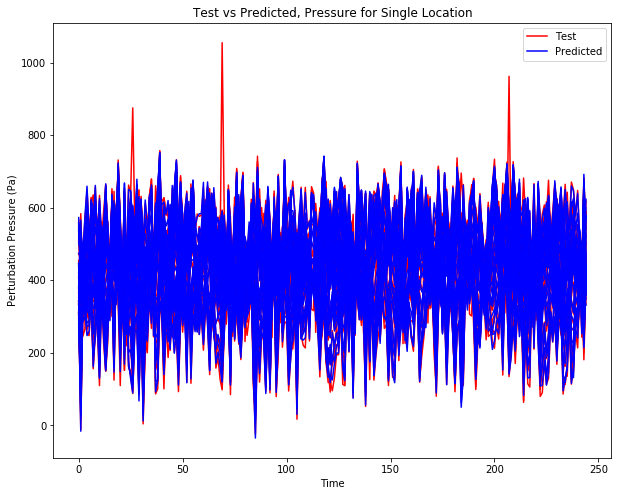

In [219]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Pressure for Single Location')
plt.xlabel('Time')
plt.ylabel('Perturbation Pressure (Pa)')
plt.plot(y_test_p, 'r',label='Test')
plt.plot(predicted_p, 'b',label='Predicted')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.legend()
plt.savefig('Pressure for Single Location.png')
plt.show()

### We can see a few outliers but overall plot looks good, almost all test data points are covered by predicted data. To get a closer look lets plot the single time and location

In [161]:
predicted_p[4].shape

(29,)

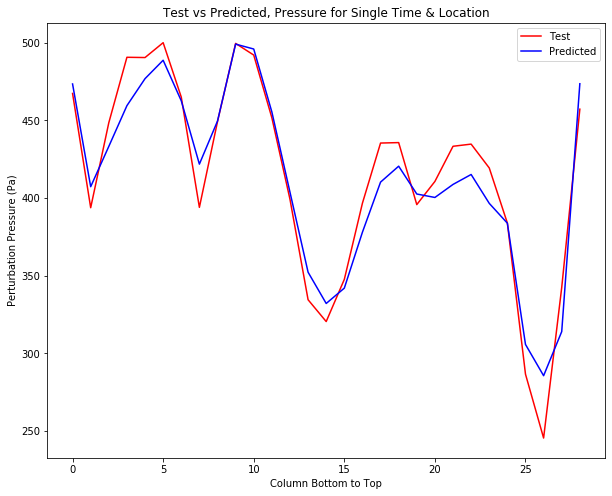

In [223]:
plt.figure(figsize=(10,8))
plt.title('Test vs Predicted, Pressure for Single Time & Location')
plt.xlabel('Column Bottom to Top')
plt.ylabel('Perturbation Pressure (Pa)')
plt.plot(y_test_p[2], 'r', label='Test')
plt.plot(predicted_p[2], 'b', Label = 'Predicted')
plt.legend()
plt.savefig('Pressure for Single Time & Location_1.png')
plt.show()

### Model is able to capture the spikes of the data and able emulate almost accurately

In [127]:
model_p = auto_model_p.export_model()

In [208]:
f = open("Pressure_Model_config.txt", "w")
f.write(str(model_p.get_config()))
f.close()

# Plotting Map

In [5]:
from mpl_toolkits.basemap import Basemap
import pandas as pd
import argparse
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
minLat=-20
maxLat=80
minLon=-180
maxLon=30

In [7]:

pre = list(np.concatenate(predicted_p).flat)

NameError: name 'predicted_p' is not defined

In [251]:
predicted_p.shape

(245, 29)

In [250]:
len(latitude)

841

In [255]:
data['longitude'][1][1]

-120.32599

In [247]:
data['latitude'][1][1]


4.171837

In [18]:
data['temperature'][0][15][13]

masked_array(data=[16.8238525390625, 15.947967529296875, 14.93603515625,
                   14.04736328125, 13.439849853515625, 12.974365234375,
                   12.67816162109375, 12.6533203125, 13.129913330078125,
                   13.582366943359375, 13.03375244140625,
                   12.209625244140625, 12.048675537109375,
                   12.676116943359375, 13.18231201171875,
                   13.990997314453125, 14.38385009765625,
                   14.21478271484375, 14.072601318359375,
                   13.42913818359375, 13.2918701171875,
                   13.554229736328125, 13.126739501953125,
                   12.7545166015625, 12.71087646484375,
                   13.279876708984375, 14.353057861328125,
                   15.508880615234375, 15.679840087890625],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, Fals

In [15]:
temperature_0=data['temperature'][0][15][13]

In [11]:
temperature_0=[]
pressure_0=[]
for lat in range(29):
    for lon in range(29):
        temperature_0.append(data['temperature'][28][lat][lon])
        pressure_0.append(data['pressure'][0][lat][lon][0])

In [282]:
len(temperature_0)

841

In [30]:
temperature=list(np.concatenate(data['temperature'][0][0]).flat)

In [77]:
temperature=list(np.concatenate(data['temperature'][0][0]).flat)
latitude = list(np.concatenate(data['latitude']).flat)
longitude = list(np.concatenate(data['longitude']).flat)
pressure=list(np.concatenate(data['pressure'][0][0]).flat)

In [32]:
len(latitude)

841

841


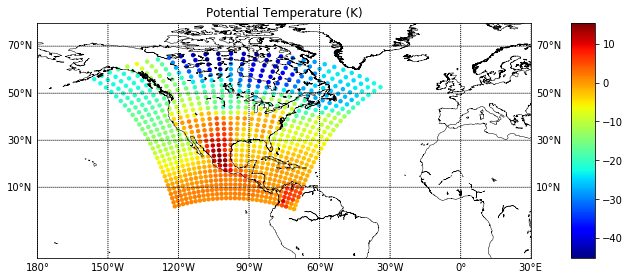

In [33]:
plt.figure(figsize=(10,8))
m = Basemap(projection='cyl', resolution='l',llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat,lat_0=20.,lon_0=-10.,lat_ts=10.)
#'cyl'
#m = Basemap(projection='cyl', resolution='l',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, lat_1=32,lat_2=45,lon_0=-95)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
#GET OCO2 DATA
'''# filter to get oco2 and gosat data seperately
oco2_data = data_set[data_set['dstype'].str.contains("oco2")]
print('Number of OCO2 rows= ' + str(len(oco2_data)))
'''
#    plt.clim(380, 420)
lon_oco2 = np.array(longitude)
lat_oco2 = np.array(latitude)
yrecon_oco2 = np.array(temperature)

print(len(yrecon_oco2))
m.scatter(lon_oco2, lat_oco2, c=yrecon_oco2, s=20, cmap=plt.cm.jet, edgecolors=None, linewidth=0)
m.colorbar(mappable=None, location='right', size='5%', pad='8%', fig=None, ax=None)
plt.title("Potential Temperature (K) level 0")
#plt.savefig('Potential_Temperature.png')
plt.show()


841


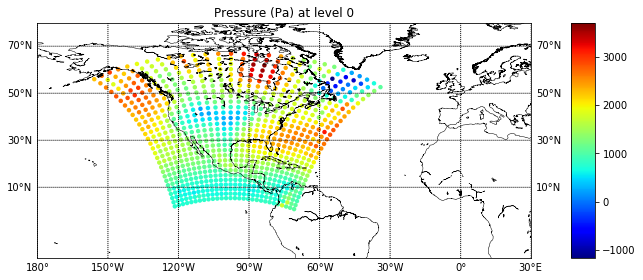

In [79]:
plt.figure(figsize=(10,8))
m = Basemap(projection='cyl', resolution='l',llcrnrlon=minLon, llcrnrlat=minLat, urcrnrlon=maxLon, urcrnrlat=maxLat,lat_0=20.,lon_0=-10.,lat_ts=10.)
#'cyl'
#m = Basemap(projection='cyl', resolution='l',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, lat_1=32,lat_2=45,lon_0=-95)
m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
# draw meridians
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])
#GET OCO2 DATA
'''# filter to get oco2 and gosat data seperately
oco2_data = data_set[data_set['dstype'].str.contains("oco2")]
print('Number of OCO2 rows= ' + str(len(oco2_data)))
'''
#    plt.clim(380, 420)
lon_oco2 = np.array(longitude)
lat_oco2 = np.array(latitude)
yrecon_oco2 = np.array(pressure)

print(len(yrecon_oco2))
m.scatter(lon_oco2, lat_oco2, c=yrecon_oco2, s=20, cmap=plt.cm.jet, edgecolors=None, linewidth=0)
m.colorbar(mappable=None, location='right', size='5%', pad='8%', fig=None, ax=None)
plt.title("Pressure (Pa) at level 0")
plt.savefig('Pressure (Pa) level 0.png')
plt.show()

In [254]:
data['temperature'][1].shape

(29, 29, 29)

In [253]:
data['temperature'].shape

(744, 29, 29, 29)

In [278]:
len(data['times'])

744

In [279]:
data['latitude'].shape

(29, 29)

In [77]:
d = 0.75
#activate='LeakyReLu'   # change to act funct if needed e.g sigmoid
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
#model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
#model.add(tf.keras.layers.LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(d))
model.add(tf.keras.layers.LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dropout(d))
#model.add(Dropout(d))
#model.add(LSTM(FLAGS.n_hidden, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activate, return_sequences=True))
#model.add(LSTM(FLAGS.n_hidden, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activate, return_sequences=False))
model.add(tf.keras.layers.Dense(1))
#sgd = tf.keras.optimizers.SGD(lr=0.0015, decay=1e-6, momentum=0.9, nesterov=True)
adam=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,name='Adam')
model.compile(loss=my_objective, optimizer=adam)

AttributeError: 'RNNBlock' object has no attribute 'fit'

In [20]:
flat_temperature =list(np.concatenate(temperature).flat)
flat_pressure = list(np.concatenate(pressure).flat)
flat_xWind = list(np.concatenate(xWind).flat)
flat_yWind = list(np.concatenate(yWind).flat)
flat_zWind =list(np.concatenate(zWind).flat)
flat_no2= list(np.concatenate(no2).flat)
flat_no = list(np.concatenate(no).flat)
flat_o3 = list(np.concatenate(o3).flat)
flat_hno3 = list(np.concatenate(hno3).flat)
flat_h2o2 = list(np.concatenate(h2o2).flat)

In [21]:
df = pd.DataFrame(list(zip(flat_temperature,flat_pressure,flat_xWind,flat_yWind,flat_zWind,flat_no2, flat_no,flat_o3,flat_hno3,flat_h2o2)),columns =['temperature','pressure','xWind','yWind','zWind','no2', 'no','o3','hno3','h2o2'])

In [22]:
df.shape

(21576, 10)

In [23]:
df.head()

,temperature,pressure,xWind,yWind,zWind,no2,no,o3,hno3,h2o2
0,16.823853,556.183594,7.196385,-1.436874,-0.010515,0.000039,0.000013,0.047917,0.000108,0.001103
1,15.947968,530.468750,5.494700,-3.421114,-0.010478,0.000050,0.000017,0.049584,0.000178,0.000992
2,14.936035,493.621094,6.351919,-4.918729,-0.029001,0.000064,0.000021,0.051173,0.000260,0.000888
3,14.047363,478.058594,6.461870,-3.480983,-0.002807,0.000075,0.000025,0.052018,0.000320,0.000834
4,13.439850,445.917969,6.308065,-3.467795,-0.011003,0.000079,0.000026,0.052187,0.000338,0.000827


In [8]:
flat_no2= list(np.concatenate(data['no2']).flat)
flat_no = list(np.concatenate(data['no']).flat)
flat_o3 = list(np.concatenate(data['o3']).flat)
flat_hno3 = list(np.concatenate(data['hno3']).flat)
flat_h2o2 = list(np.concatenate(data['h2o2']).flat)

In [9]:
df = pd.DataFrame(list(zip(flat_no2, flat_no,flat_o3,flat_hno3,flat_h2o2)),columns =['no2', 'no','o3','hno3','h2o2'])

In [10]:
df.shape

(18145416, 5)

In [19]:
18145416 - 121945

18023471

In [20]:
df_train = df.iloc[:18023471,:]
df_test = df.iloc[18023471:,:]

In [33]:
df_train.iloc[:,-1:]

,h2o2
0,0.001380
1,0.001380
2,0.001379
3,0.001379
4,0.001379
...,...
18023466,0.000815
18023467,0.000815
18023468,0.000815
18023469,0.000815


In [34]:
X_train = df_train.iloc[:,:4]
y_train = df_train.iloc[:,-1:]
X_test = df_test.iloc[:,:4]
y_test = df_train.iloc[:,-1:]

In [39]:
X_train.shape

(18023471, 4)

In [ ]:
learning_rate=0.0001
epochs = 10
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, input_shape=(4,), kernel_initializer='normal', activation='relu', kernel_regularizer=l2(0.1),
            activity_regularizer=l1(0.1)))
#model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(100, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))

# Compile model
#sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer='adam')
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_split=0.5, verbose=2)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_split=0.5, verbose=2)
# make a prediction
predicted = model.predict(X_test)

Epoch 1/10
563234/563234 - 878s - loss: 6.3459e-06 - val_loss: 1.5275e-07
Epoch 2/10
563234/563234 - 880s - loss: 1.0823e-07 - val_loss: 8.6608e-08
Epoch 3/10
563234/563234 - 878s - loss: 1.0818e-07 - val_loss: 1.1065e-07
Epoch 4/10
563234/563234 - 875s - loss: 1.0817e-07 - val_loss: 1.0361e-07
Epoch 5/10
563234/563234 - 875s - loss: 1.0825e-07 - val_loss: 1.0830e-07
Epoch 6/10
563234/563234 - 877s - loss: 1.0824e-07 - val_loss: 9.3466e-08
Epoch 7/10


In [41]:
predicted

array([[0.00077412],
       [0.00077412],
       [0.00077412],
       ...,
       [0.00077412],
       [0.00077412],
       [0.00077412]], dtype=float32)

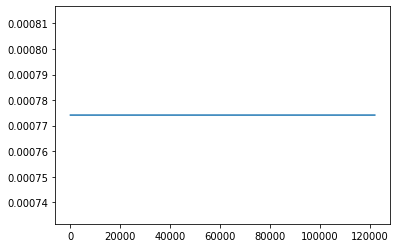

In [42]:
plt.plot(predicted)

In [36]:
X_train.shape

(18023471, 4)

In [ ]:
X_train = df_train.i

In [21]:
df_train.shape

(18023471, 5)

In [22]:
df_test.shape

(121945, 5)